<center>

## *Introducción a la Ciencia de Datos y sus Metodologías*
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="150">
</p>

#### Proyecto Final
</center>

Daniel Eduardo Vázquez Espinoza

------------------------------------------
*Indicaciones* : 

    El proyecto consiste en desarrollar una aplicación que permita analizar información contenida en una base de datos en SQL.
    
    Puede ser una libreta en jupyter notebook que permita la consulta de una base de datos, analice y presente dicho análisis ya sea a través de una gráfica o tabla que describa dicho análisis.

    Es indispensable que la base de datos a tratar contenga, al menos una vista, un procedimiento almacenado y una función. 

    Documentar bien cada una de las fases del código de tal manera que pueda ser fácilmente reproducible.

    Utilizar plataformas como github para almacenar la base de datos.

    Presentar un documento (Informe técnico) que describa el desarrollo del proyecto final (Documento a anexar), que incluya toda la información relacionada con el proyecto. Es decir, una breve descripción, objetivos, fuente de datos, desarrollo, referencias... a tal grado que dicho informe pueda convertirse en una entrada a medium.



__________________________________________________________________________
### Introduccion

En este proyecto se utilizaran los datos abiertos de [Incidencia Delictiva](https://www.gob.mx/sesnsp/acciones-y-programas/datos-abiertos-de-incidencia-delictiva?state=published) en formato CSV del Secretariado Ejecutivo del Sistema Nacional de Seguridad Pública. 

A continuación se muestra una descripción de las columnas que componen la tabla:

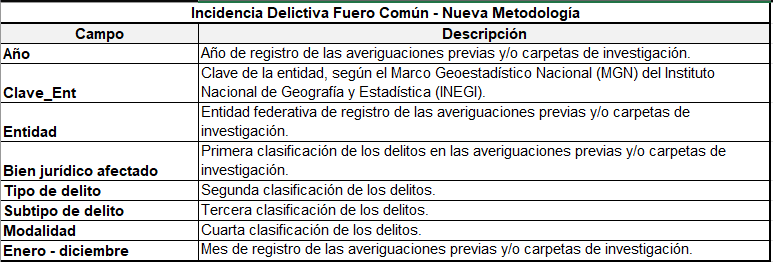


-----------------------------------------------------------
### Importar CSV a MySQL Workbench

Comenzamos creando una base de datos llamada "incidencias" y definimos que la vamos a utilizar.

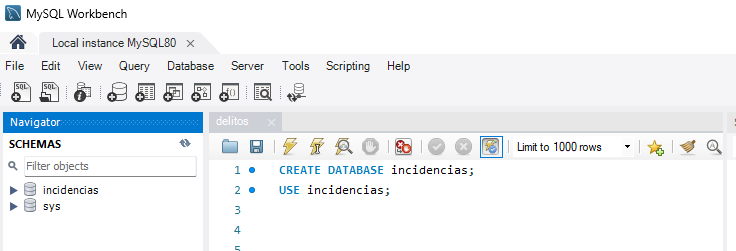

Utilizamos la opcion "Table Data Import Wizard" para importar el archivo CSV

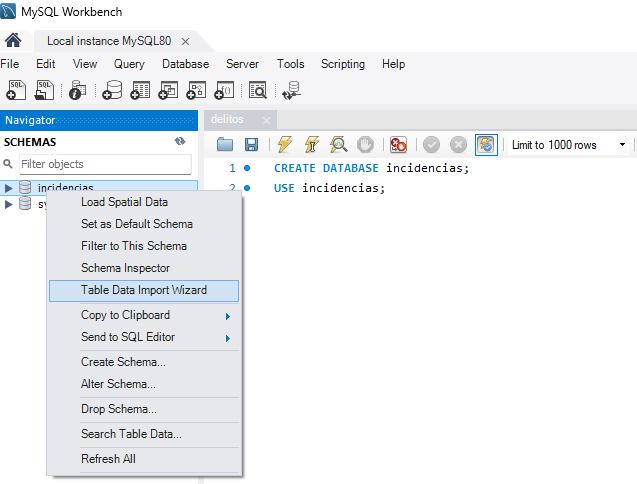

Despues de unos minutos podremos ver los datos en la pestaña de tables, en este caso el CSV se renombro a "delitos".
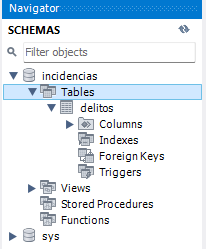

Utilizar el siguiente script para crear las tablas y vistas directamente en MSQL, que usaremos mas adelante.

-- Creacion de una vista  eliminando registros ceros 
CREATE OR REPLACE VIEW delitos_sincero AS
Select * from delitos where Enero!= 0 or Febrero!= 0 or Marzo!= 0 or Abril!= 0 or Mayo != 0 or Junio!= 0 or Julio != 0 or 
Agosto != 0 or Septiembre != 0 or Octubre != 0 or Noviembre != 0 or Diciembre!= 0 GROUP BY Año, Municipio, Modalidad;

-- Tabla con columna que suma las delitos.
DROP TABLE IF EXISTS delitos_totales;
CREATE TABLE delitos_totales AS
SELECT *,SUM(Enero+Febrero+Marzo+Abril+Mayo+Junio+Julio+Agosto+Septiembre+Octubre+Noviembre+Diciembre) as "Incidencias_Totales" 
FROM delitos_sincero GROUP by Año,Municipio,Modalidad;


-- Vista con el total de delitos por entidad
CREATE OR REPLACE VIEW Entidad_total AS
SELECT Entidad,SUM(Incidencias_Totales) AS suma_delitos FROM delitos_totales GROUP BY Entidad ORDER BY suma_delitos DESC;

---------------------------------------------------------------
### Vinculacion MySQL y Python

Dentro de MySQL Workbench nos dirigimos a Database > Connect to database, para observar la informacion de port, user, y hostname que necesitaremos para crear la conexion.

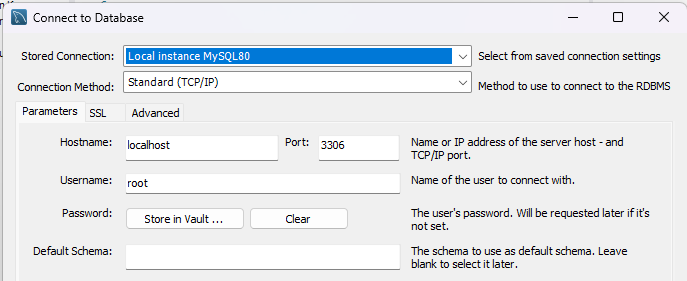

Con esta informacion creamos la cadena myDataConnect.

In [12]:
myUser = 'root'  ##USERNAME
myPass = 'CONTRASENA' ## CONTRASENA
myPort = 3306 ##PORT
myDb = 'incidencias' ## BASE DE DATOS
myhost='localhost' ## HOSTNAME

myDataConnect = [myUser, myPass,myhost, myPort, myDb]

In [20]:
myUser = 'root'  ##USERNAME
myPass = 'grg170dx' ## CONTRASENA
myPort = 3306 ##PORT
myDb = 'incidencias' ## BASE DE DATOS
myhost='localhost' ## HOSTNAME

myDataConnect = [myUser, myPass,myhost, myPort, myDb]

Necesitaremos las siguientes librerias.

In [21]:
import pandas as pd
import pymysql
import mysql.connector
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

La funcion "EjecutaConsulta" nos ayudara a conectarnos a la base de datos, solicitar la consulta, extraerla en un dataframe y cerrar la conexion.

In [25]:
def EjecutaConsulta(consulta, connString): 
  # create cursor
  connection = pymysql.connect(user=connString[0],
                            password=connString[1],
                            host=connString[2],
                            port=connString[3],
                            db=connString[4])   
  cursor=connection.cursor()

  try:
    query = consulta
    cursor.execute(query)

    result = cursor.fetchall()
    field_names = [i[0] for i in cursor.description]
    df = pd.DataFrame(result, columns=field_names)
    
    connection.close()

    return df
  except:
    connection.close()
    return None

A la funcion "EjecutaConsulta" le compartimos el query  y la informacion de nuestra base de datos, ejecuta la solicitud y la transforma a un dataframe.

In [28]:
query = "Select * from delitos_totales;"
df_delitos = EjecutaConsulta(query, myDataConnect)
df_delitos.head()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Incidencias_Totales
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1,0,1,1,0,2,1,0,1,10
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0,0,1,0,1,0,0,0,0,4
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1,3,2,0,1,2,0,0,0,10
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,1,0,0,0,0,0,0,0,0,2
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,En accidente de tránsito,9,...,11,6,4,6,6,11,6,3,7,82


---------------------------------------------------------------------
### Graficar Por Query

Solicitamos las vistas creadas anteriormente con la funcion para convertirlas en dataframes y graficarlas.

In [30]:
query = "Select * from Entidad_total;"
df_delitos_entidad = EjecutaConsulta(query, myDataConnect)
df_delitos_entidad

,Entidad,suma_delitos
0,Ciudad de México,165912
1,Baja California,158633
2,Jalisco,144631
3,Guanajuato,130536
4,Nuevo León,97436
5,Coahuila de Zaragoza,72675
6,Puebla,70999
7,Chihuahua,54159
8,Morelos,53447
9,Guerrero,51354


<AxesSubplot:xlabel='suma_delitos', ylabel='Entidad'>

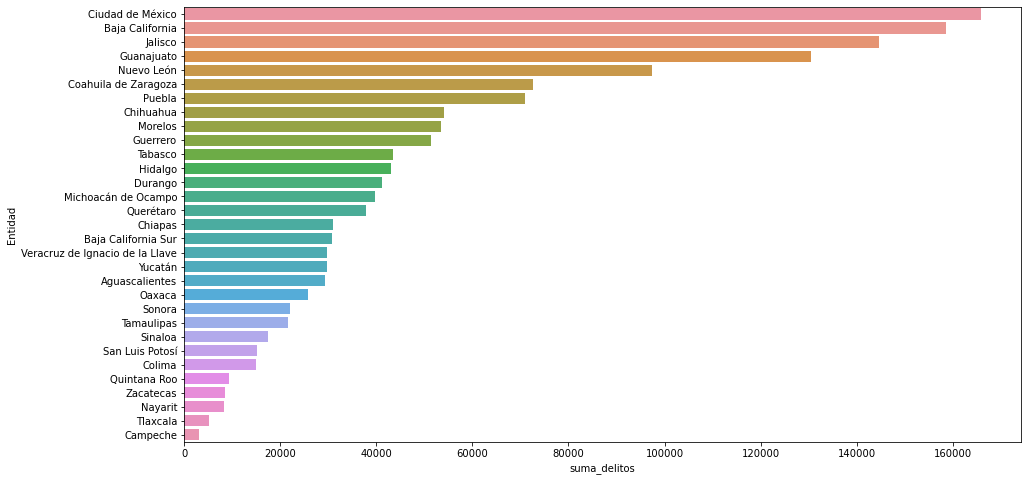

In [39]:
plt.figure(figsize = (15,8))
sns.barplot(y="Entidad", x="suma_delitos", data=df_delitos_entidad)

De igual manera es posible aplicar funciones en el query para filtar una tabla.

In [32]:
query = "SELECT `Tipo de delito`,Incidencias_Totales FROM delitos_totales WHERE Entidad = 'Sonora'GROUP BY `Tipo de delito` ORDER BY Incidencias_Totales DESC;"
delitos_sonora = EjecutaConsulta(query, myDataConnect)
delitos_sonora

,Tipo de delito,Incidencias_Totales
0,Incumplimiento de obligaciones de asistencia f...,184
1,Violencia familiar,53
2,Narcomenudeo,15
3,Abuso de confianza,8
4,Abuso sexual,8
5,Violación equiparada,5
6,Falsificación,4
7,Corrupción de menores,3
8,Otros delitos que atentan contra la libertad p...,3
9,Amenazas,3


<AxesSubplot:xlabel='Incidencias_Totales', ylabel='Tipo de delito'>

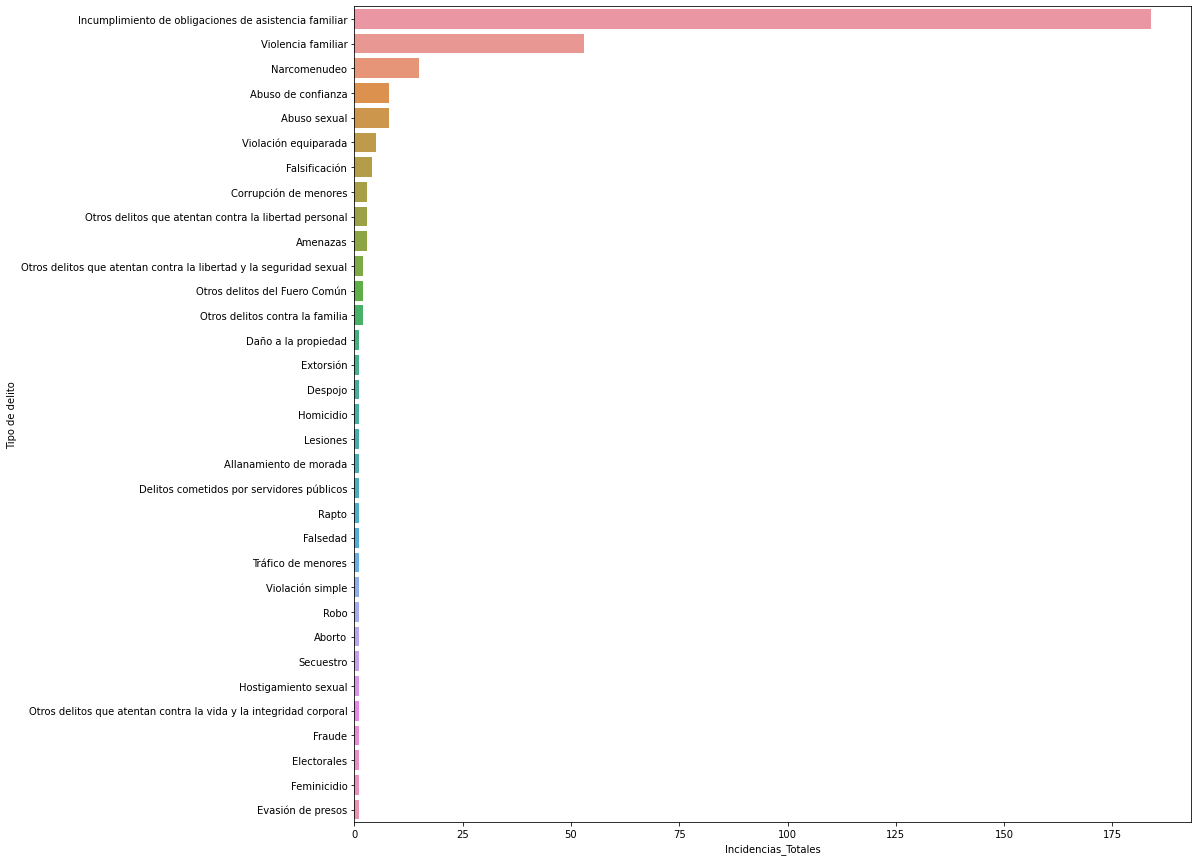

In [43]:
plt.figure(figsize = (15,15))
sns.barplot(y="Tipo de delito", x="Incidencias_Totales", data=delitos_sonora)